# Movie Recommendations with collaborative recommendations

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import defaultdict
from typing import List
from tqdm import tqdm


ModuleNotFoundError: No module named 'pandas'

### Read data

In [1]:
data = pd.read_csv('./data/ml-25m/ratings.csv', nrows=100000)
print(data.head(10))

all_movie_counts = len(data['movieId'].unique())
train_data, valid_x, train_y, valid_y = train_test_split(data, data['rating'], test_size=0.2, random_state=0)


NameError: name 'pd' is not defined

### Analyze data

Text(0, 0.5, 'popularity')

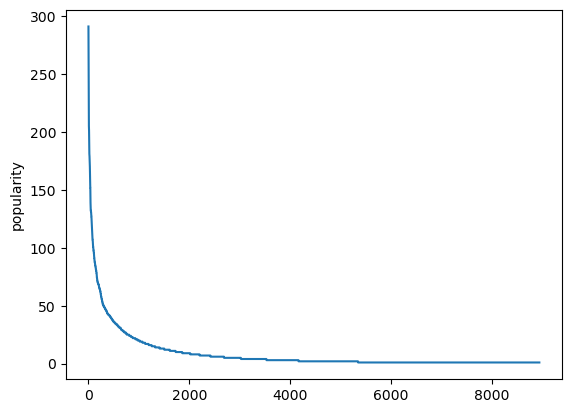

In [56]:
popularity = train_data.groupby(train_data['movieId']).size().to_list()
# print(popularity)

sorted_popularity =list(sorted(popularity, reverse=True))
# s =  map(lambda x: x[1], sorted_popularity)
plt.plot(sorted_popularity)
plt.ylabel('popularity')

### Train test split

In [57]:
# user to movies dictionary
def get_user_movie_dict(data: pd.DataFrame):
    'dict {u_id: pd}'
    return {key: values for (key, values) in data.groupby('userId')}

users = list(set(train_data['userId']))
user_movie_dict = get_user_movie_dict(train_data) 
print(len(users))

757


## User similarity calculation

In [58]:
# find user similarities
# given user U, find top K similar users
# foreach similar user v, get movies that U hasn't watched. And calculate movie recommendation score for each movie
# sort candidate movies by recommendation scores and pick the top K

def calculate_user_similarity(user_movie_dict, users) -> dict: 
    'dict: {u: {v:score}} '
    similarity_scores_dict = defaultdict(dict)
    
    for i in range(len(users)):
        for j in range(i + 1 ,len(users)):
            u = users[i]
            v = users[j]
            u_movies = set(user_movie_dict[u]['movieId'].to_list())
            v_movies = set(user_movie_dict[v]['movieId'].to_list())
            movies_common = u_movies.intersection(v_movies)
            
            score = len(movies_common) / np.sqrt(len(u_movies) * len(v_movies))            
            similarity_scores_dict[u][v]= score            
            similarity_scores_dict[v][u]=score
    return similarity_scores_dict

user_similarity_score = calculate_user_similarity(user_movie_dict, users)

In [59]:

def get_top_k_similar_users(user_id: int|str, user_similarity_score : dict, k: int = 10) -> List: 
    'return list of {user_id, similarity score}'
    similar_users = user_similarity_score.get(user_id, {}) # {u_1:0.2, v3: 0.3}
    res = sorted(similar_users.items(), key=lambda x: x[1], reverse=True)
    return [x for x in res[:k]]
    
similar_users = get_top_k_similar_users(1, user_similarity_score, 5)
# print(similar_users)

## Recommend based on user similarity

In [60]:

def recommended_movies(user_id, user_movie_dict, user_similarity_score,  k) -> List: 
    'list of movie_id'
    candidate_movies = defaultdict(float) # movie_id, recommendation score
    # find top N similar users    
    user_watched_movies = set(user_movie_dict[user_id]['movieId'].to_list())
    similar_users = get_top_k_similar_users(user_id, user_similarity_score,  k)
    
    for user_v, similarity_score in similar_users:
        user_v_movies = user_movie_dict[user_v]
        for index, movie in user_v_movies.iterrows():
            if movie['movieId'] not in user_watched_movies:
                candidate_movies[movie['movieId']] += similarity_score * movie['rating']

    recommendation = sorted(candidate_movies.items(), key=lambda mv: mv[1], reverse=True)
    return [int(x[0]) for x in recommendation[:k]]

suggestions = recommended_movies(1, user_movie_dict, user_similarity_score, 20)
print(suggestions)


[5952, 4306, 318, 7153, 4226, 527, 356, 4993, 4886, 1206, 1089, 593, 2571, 1270, 7361, 47, 110, 1704, 4963, 2762]


### Test on validation dataset

In [68]:
valid_user_movies ={key:value['movieId'].to_list() for (key, value) in get_user_movie_dict(valid_x).items()}

In [67]:
# test movie data,
# user_movie data
# recommend movie
valid_user_movies ={key:value['movieId'].to_list() for (key, value) in get_user_movie_dict(valid_x).items()}
valid_user_movies = get_user_movie_dict(valid_x)
valid_recommendation = {}
for user_id in tqdm(valid_user_movies.keys()):
     recomendatation = recommended_movies(user_id, user_movie_dict, user_similarity_score, 20)
     valid_recommendation[user_id] = recomendatation

KeyboardInterrupt: 

### Metrics


In [72]:
# calc metrics given recommendations and actual movies the users watched. 
# Presision rate = hit / recommended count; recall rate = hit/ actual watched movies; coverage = commendated count/ all movie count.

def calc_metrics(user_recommendated_movies, user_actual_watched_movies, all_movie_counts, n=10000) -> dict:
    hit, user_actual_watched_movies_count, recommended_movies_count = 0, 0, 0
    all_movie_rec = set()
    for user_id, reco in user_recommendated_movies.items():        
        actual_watched_movies = set(user_actual_watched_movies[user_id])
        rec = set(reco[:n])
        hit += len(actual_watched_movies & rec)
        user_actual_watched_movies_count += len(actual_watched_movies)
        recommended_movies_count += len(reco)
        all_movie_rec =all_movie_rec.union(rec)

    return {"precision_rate": hit / recommended_movies_count, "recall_rate": hit / user_actual_watched_movies_count, "coverage_rate": len(all_movie_rec)/all_movie_counts}


metrics = calc_metrics(valid_recommendation, valid_user_movies, all_movie_counts, 10)
print(metrics)

{'precision_rate': 0.12169312169312169, 'recall_rate': 0.092, 'coverage_rate': 0.03300633558144288}


In [76]:
metrics = {}
for i in range(5, 10, 5):
    metrics[i] = calc_metrics(valid_recommendation, valid_user_movies, all_movie_counts, i)    
df = pd.DataFrame(metrics)
print(df)

                      5         15        25        35        45        55
precision_rate  0.070503  0.164683  0.199405  0.199405  0.199405  0.199405
recall_rate     0.053300  0.124500  0.150750  0.150750  0.150750  0.150750
coverage_rate   0.023401  0.042203  0.050174  0.050174  0.050174  0.050174


### Train model

### Evaluate model

### Predit on test dataset


### Output

In [ ]:

# df = pd.DataFrame()
# df.to_csv('submission.csv',index = False, header=True)